<a href="https://colab.research.google.com/github/csoren66/Deep-Learning/blob/main/Text_Classification_Using_BERT_%26_Tensorflow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd
df = pd.read_csv('/content/spam.csv',encoding="ISO-8859-1")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [36]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [37]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [38]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [39]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [40]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [41]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [42]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [43]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [44]:
df_balanced.sample(5)

,Category,Message
2830,spam,Send a logo 2 ur lover - 2 names joined by a h...
1126,spam,For taking part in our mobile survey yesterday...
273,spam,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...
2700,ham,Oh baby of the house. How come you dont have a...
4048,spam,"Thanks for your ringtone order, reference numb..."


In [45]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2663,spam,Hello darling how are you today? I would love ...,1
3561,ham,Lol I know! Hey someone did a great inpersonat...,0
2383,ham,I will reach before ten morning,0
3631,spam,Get the official ENGLAND poly ringtone or colo...,1
2037,ham,You can jot down things you want to remember l...,0


**Split it into training and test data set**

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [47]:
X_train.head(4)

1887    Dear 0776xxxxxxx U've been invited to XCHAT. T...
1120    Bored of speed dating? Try SPEEDCHAT, txt SPEE...
3893    URGENT This is our 2nd attempt to contact U. Y...
4965    Dear Voucher holder Have your next meal on us....
Name: Message, dtype: object

Now lets import BERT model and get embeding vectors for few sample statements

In [48]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [49]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132726 , -0.8884571 , ..., -0.7474883 ,
        -0.75314724,  0.91964495],
       [-0.8720837 , -0.50543964, -0.94446695, ..., -0.858475  ,
        -0.7174535 ,  0.88082975]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [50]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [51]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76069176, -0.14219369,  0.4960466 , ...,  0.4216536 ,
        -0.532214  ,  0.80312186],
       [-0.8602321 , -0.21242929,  0.49156943, ...,  0.39798057,
        -0.6050629 ,  0.8447166 ],
       [-0.7128863 , -0.15463915,  0.38401636, ...,  0.35278702,
        -0.5099134 ,  0.7347411 ],
       [-0.8253345 , -0.35550582, -0.59069693, ..., -0.01613748,
        -0.6141758 ,  0.8723029 ],
       [-0.75041324, -0.2681261 , -0.26689634, ...,  0.02839412,
        -0.59380966,  0.7974985 ],
       [-0.78544337, -0.29949665,  0.41027415, ...,  0.5222541 ,
        -0.49573532,  0.81507486]], dtype=float32)>

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits


In [22]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703815]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [23]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

# Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [53]:
# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype= tf.string, name = 'text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [55]:
len(X_train)

1120

In [56]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [59]:
model.fit(X_train, y_train, epochs=1)

35/35 [==============================] - 507s 14s/step - loss: 0.6053 - accuracy: 0.6938 - precision: 0.6874 - recall: 0.7107


In [58]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 173s 14s/step - loss: 0.6652 - accuracy: 0.5989 - precision: 0.6907 - recall: 0.3583


[0.6652228236198425,
 0.5989304780960083,
 0.6907216310501099,
 0.3582887649536133]

In [60]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [61]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[108,  79],
       [  9, 178]])

Text(33.0, 0.5, 'Truth')

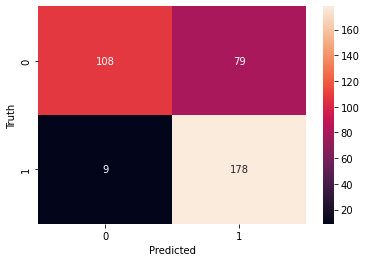

In [63]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [64]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.58      0.71       187
           1       0.69      0.95      0.80       187

    accuracy                           0.76       374
   macro avg       0.81      0.76      0.76       374
weighted avg       0.81      0.76      0.76       374



Inference

In [65]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.6846379 ],
       [0.67931104],
       [0.69659513],
       [0.5335005 ],
       [0.47706604]], dtype=float32)